# **Business and Industrial Development in Pathum-Thani with a RAG Chatbot**

## **Development Tools and Libraries**

### PDF to Text Conversion
- **[PyPDF2](https://pypdf.readthedocs.io/en/stable/) :** PDF ที่มีโครงสร้างชัดเจน มี visitor function ที่กำหนดส่วนของ PDF ที่จะดึงออกมาได้
- **[LlamaIndex Parse](https://cloud.llamaindex.ai/landing) :** PDF ที่มีโครงสร้างซับซ้อน ใช้สำหรับการดึง text จาก PDF โดยเฉพาะใน file ที่มี format เป็นตารางหรือกราฟจะทำได้ดี convert text ที่ extract ออกมาแล้วเป็น MD ที่มี structure

### Embedding Model
- **[BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) :** รองรับภาษาไทย (th) โดยสามารถทำงานแบบ Multi-Functionality คือ Dense, Sparse และ Colbert Retrievals ได้ในโมเดลเดียว รองรับความยาวของ Document สูงสุด 8192 tokens สามารถนำไปใช้กับ Re-ranking models ได้อย่างมีประสิทธิภาพ ช่วยเพิ่มความแม่นยำในการเลือกข้อมูลที่เกี่ยวข้องเพื่อนำมาสร้างคำตอบ

### Vector Database
- **[FAISS](https://github.com/facebookresearch/faiss) :** เป็นไลบรารีที่พัฒนาโดย Facebook AI Research เป็นเครื่องมือสำหรับทำงานด้าน similarity search และ clustering dense vectors โดยมีข้อดีคือทำ Vector Indexing and Searching เช่น flat (brute-force), inverted file, และ hierarchical navigable small world (HNSW) รองรับ CPU และ GPU สำหรับ accelerate the indexing and searching process สามารถสร้าง Semantic Cache ระหว่าง user’s question and the required data เพื่อลดเวลาในการ retrieval ข้อมูลได้มากถึง 95% และจะ store search results ไว้ เพื่อนำกลับมาใช้ใหม่ได้ หากมีคำถามที่คล้ายคลึงกันในภายหลัง

### LLM Generation Model
- **[typhoon-v1.5x-70b-instruct](https://opentyphoon.ai/app/api-key) :** มี Performance ใกล้เคียงกับ GPT-4-0612 ในภาษาไทย เนื่องจาก Fine tune บน Dataset ที่เป็นภาษาไทย  optimized for application use cases, Retrieval-Augmented Generation (RAG), constrained generation, and reasoning tasks ใช้เทคนิค Cross-lingual Transfer เข้ากับ Llama 3 Instruct ทำให้ได้โมเดลที่ทั้งเข้าใจภาษาไทยและตอบสนองต่อคำสั่งได้ดี


### **High level design for development**

![Image Description](https://drive.google.com/uc?id=1cy4XQjHZfZ4xF1WWLyJbcL2oneiztAKM)


### **Install Tools and Libraries required for operation**

In [ ]:
requirements = [
    "langchain",
    "langchain-community",
    "fastembed",
    "python-dotenv",
    "chainlit",
    "sentence-transformers",
    "openai==1.55.3",
    "joblib",
    "gdown",
    "faiss-cpu",
    "nest-asyncio",
    "unstructured[md]",
    "pypdf",
    "gradio",
    "llama_parse"
]

file_path = "requirements.txt"
with open(file_path, "w") as f:
    for package in requirements:
        f.write(f"{package}\n")

In [ ]:
!pip install -r requirements.txt
!pip install -U FlagEmbedding
!pip install --upgrade "httpx<0.28.0"
!pip install renumics-spotlight
!pip install tensorflow tensorboard
!pip install umap-learn

In [ ]:
import os
import json
import joblib
import gdown
import time
import httpx
import re

import openai
from collections import deque
from openai import OpenAI
from typing import List, Dict, Tuple
from llama_parse import LlamaParse

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

import gradio as gr

## **PDF to Text**

PDF file มีความซับซ้อน ประกอบด้วยองค์ประกอบที่ค่อนข้างหลากหลาย เช่น ข้อความ รูปภาพ และองค์ประกอบแบบ Interactive ในทาง Technically PDF สร้างขึ้นโดยใช้ภาษา PostScript ซึ่งอธิบายโครงสร้างและกราฟิกของเอกสาร  ความซับซ้อนนี้ทำให้ต้องมีวิธีการดึงข้อมูลที่แตกต่างกันไป  ขึ้นอยู่กับเนื้อหาของเอกสาร


### **Conditions for selecting Tools for Extract Text**

* **PDF ที่มีโครงสร้างชัดเจน :**  PDFMiner, PDFQuery และ LlamaParse เป็นตัวเลือกที่ดี เนื่องจากสามารถดึงข้อมูลและจัดเรียงตามโครงสร้าง logically ได้
* **PDF ที่มีโครงสร้างซับซ้อน :** LlamaParse เป็นตัวเลือกที่ดีที่สุด  เนื่องจากสามารถจัดการกับตำแหน่งของข้อความได้ค่อนข้างแม่นยำ

![Image Description](https://drive.google.com/uc?id=1dXaGw82RRHGB-yBkWaOMOhbz1rPIaGJp)

REF : https://medium.com/@bpmcgough/comparing-pdf-parsers-1b9f5ae24afe

เอกสาร PDF ที่ใช้สำหรับสร้าง RAG Chatbot มีรูปแบบและโครงสร้างที่หลากหลายและซับซ้อน เช่น รูปภาพ Infographic, ตาราง, และข้อความที่ไม่มีโครงสร้างที่ชัดเจน ทำให้การเลือกเครื่องมือดึงข้อมูลที่มีประสิทธิภาพเป็นไปได้ยาก เครื่องมือทั่วไปมักจะทำงานได้ไม่ดีกับเอกสารที่มีความซับซ้อนเช่นนี้ อาจดึงข้อมูลได้ไม่ครบถ้วน สูญเสียบริบทสำคัญ หรือจัดรูปแบบข้อมูลผิดพลาด ส่งผลต่อประสิทธิภาพของ Chatbot

ด้วยเหตุนี้ คณะผู้จัดทำจึงเลือกใช้ LlamaParse เนื่องจากมีความสามารถที่ครอบคลุมและเหมาะสมกับความท้าทายดังกล่าว โดยเฉพาะอย่างยิ่งความสามารถในการจัดการกับเอกสารที่มีองค์ประกอบหลากหลาย รวมถึงการดึงข้อมูลตารางและรูปภาพได้อย่างแม่นยำ และแปลงข้อมูลให้อยู่ในรูปแบบที่เหมาะสมกับการใช้งานใน RAG ส่งผลให้ Chatbot สามารถเข้าถึงและประมวลผลข้อมูลได้อย่างมีประสิทธิภาพ และให้คำตอบที่ถูกต้องและแม่นยำยิ่งขึ้น





### **LlamaParse**

LlamaParse เป็น document parsing system ที่มีความสามารถสำหรับ Extract โครงสร้างและความสัมพันธ์ขององค์ประกอบต่าง ๆ ภายในเอกสารได้ ซึ่งเป็นจุดเด่นที่สำคัญ เนื่องจากเอกสารหลายประเภท โดยเฉพาะเอกสารทางเทคนิค รายงาน หรือ academic article มักมีโครงสร้างที่ซับซ้อน ประกอบด้วยหัวข้อ ย่อหน้า ตาราง รูปภาพ และองค์ประกอบที่เชื่อมโยงกัน การ Extract แค่ข้อความอย่างเดียวอาจทำให้สูญเสียบริบทและความสัมพันธ์ที่สำคัญเหล่านี้ไป

LlamaParse แก้ปัญหานี้ด้วยความสามารถในการ parse documents ที่มีโครงสร้างซับซ้อน รวมถึงการจัดการกับ embedded objects เช่น ตารางและรูปภาพ ซึ่งมักเป็นส่วนสำคัญที่มีข้อมูลเชิงลึก แทนที่จะข้ามองค์ประกอบเหล่านี้ LlamaParse สามารถดึงข้อมูลและแปลงให้อยู่ใน Format เข้าใจได้ เช่น แปลงตารางเป็นข้อมูลแบบตาราง หรือดึง caption ของรูปภาพออกมา ทำให้สามารถนำข้อมูลเหล่านี้ไปใช้ประโยชน์ต่อได้ เช่น การสร้าง knowledge graph หรือสร้าง RAG system และยังมี tools และ library ที่ออกแบบมาเพื่อระบบ retrieval โดยเฉพาะ ซึ่งทำให้การค้นหาข้อมูลจากเอกสารที่มีโครงสร้างหลากหลาย เช่น เอกสารที่มีทั้งข้อความ ตาราง และรูปภาพ เป็นไปได้อย่างมีประสิทธิภาพ ส่งผลให้การนำข้อมูลไปใช้ในงานต่างๆ เช่น การสร้าง chatbot ที่สามารถตอบคำถามจากเอกสารได้อย่างแม่นยำ หรือ การวิเคราะห์ข้อมูลเชิงลึกจากเอกสาร ทำได้ดียิ่งขึ้น

เพื่อให้ได้ข้อมูลที่ถูกต้องและมีคุณภาพสูงสุด คณะผู้จัดทำจึงเลือกใช้ LlamaIndex ที่ทำงานบน Cloud system ร่วมกับ LlamaParse ในการ extract PDF to text ภาพรวมคือสามารถ Custom Parse Settings Mode ของ LlamaParse ได้อย่างละเอียด ทำให้สามารถปรับแต่งการแยกวิเคราะห์ข้อมูลให้เหมาะสมกับ PDF หรือ Document แต่ละประเภทได้ เช่น การกำหนดวิธีการดึงข้อมูลจากตาราง การจัดการกับรูปภาพ หรือการกำหนดรูปแบบของ output ที่ต้องการ (ในที่นี้คณะผู้จัดทำเลือก Markdown Format เนื่องจาก Input เป็น PDF) เพราะเอกสารแต่ละชนิดมีโครงสร้างและรูปแบบที่แตกต่างกัน การปรับแต่ง Parse Settings ให้เหมาะสม จะช่วยให้ได้ข้อมูลที่ครบถ้วนและถูกต้องที่สุด นอกจากนี้ ยังสะดวกกว่าการเรียกใช้ APIs โดยตรง เพราะไม่ต้องจัดการกับความซับซ้อนของการ Authentication, Rate Limiting, และ Error Handling ด้วยตนเอง

![Image Description](https://drive.google.com/uc?id=1lPGJUan3JIsZjXyqGpd-Tb8_7ZyrwqfX)

REF : https://www.llamaindex.ai/llamaparse

### **Extracting text from PDF documents Using LlamaParse on Cloud**


![Image Description](https://drive.google.com/uc?id=1z_pjOL2vwkjVBQig-U440A84BOJ6tB3H)

REF : https://cloud.llamaindex.ai/project/0571876d-58a0-477f-bb4f-aa14aaf9a556/parse

In [ ]:
""" Download ไฟล์หลังจาก Extracting text from PDF documents Using LlamaParse on Cloud จาก Google Drive ตาม file_id และบันทึกไฟล์เป็น .md ใน Directory """

file_ids = [
    "1IZCmAi-5dtNXTt-8yUQaApcUx-xIqa5z",
    "1Nwm2JrHRHd98d_2eJAcYrV7YB6DjbuYC",
    "1RKEoq-d3U0HWYCWuMfNw_kKPfFcxPE8f",
    "1RLK2Y8TsmvBlm8jThqiiaVhACC72Zr4e",
    "1WMQ0U-Ex1HsEzQq5gVbhUDSdjUAajaoJ",
    "1g5nYN6sQ-vT5VvwEz-BETTTzeROjrojU",
    "1nYGLGf6vQwJTnANpFHE_0UHpuBZ2nDo6"
]

output_dir = './downloaded_markdown_files/'
os.makedirs(output_dir, exist_ok=True)

for file_id in file_ids:
    file_url = f'https://drive.google.com/uc?id={file_id}'
    output_file = os.path.join(output_dir, f"{file_id}.md")
    gdown.download(file_url, output_file, quiet=False)
    print(f"Downloaded {file_id} to {output_file}")

## Embedding model

### **Evaluating the Ideal Chunk Size for a RAG System**

การเลือก chunk_size ที่เหมาะสมจะส่งผลต่อประสิทธิภาพและความแม่นยำของระบบ RAG เช่น  Relevance and Granularity และ Response Generation Time ยกตัวอย่าง chunk_size เล็ก ๆ เช่น 128 จะทำให้ได้ chunks ที่มีความละเอียดสูง แต่ก็มีความเสี่ยงที่ข้อมูลสำคัญอาจไม่อยู่ใน chunks อันดับต้น ๆ ที่ดึงมา โดยเฉพาะอย่างยิ่งหากตั้งค่า similarity_top_k ไว้ต่ำ เช่น 2 ในขณะที่ chunk_size ใหญ่ ๆ เช่น 512 มีแนวโน้มที่จะครอบคลุมข้อมูลที่จำเป็นทั้งหมดภายใน chunks อันดับต้น ๆ ทำให้มั่นใจได้ว่าคำตอบสำหรับคำถามจะพร้อมใช้งาน แต่เมื่อ chunk_size เพิ่มขึ้น ปริมาณข้อมูลที่ส่งไปยัง LLM เพื่อสร้างคำตอบก็จะเพิ่มขึ้นเช่นกัน แม้ว่าสิ่งนี้จะช่วยให้บริบทครอบคลุมมากขึ้น แต่อาจทำให้ระบบช้าลงได้

ทางคณะผู้จัดทำจึงได้มีการทดสอบ chunk_size ที่เหมาะสมกับการใช้งานในงานนี้ โดยใช้ metrics คือ Faithfulness และ Relevancy ซึ่งวัดการไม่มี hallucinations และความเกี่ยวข้องของคำตอบตามลำดับ โดยอิงจาก query และบริบทที่ดึงมา สำหรับการพิจารณาการเลือก

![Image Description](https://drive.google.com/uc?id=1tQwWNuhQU1QQD-Z5EiJ8iKOmJwT2ZhA4)

REF : https://chunkviz.up.railway.app/

In [ ]:
from transformers import AutoTokenizer, AutoModel
import time
import numpy as np
import torch

embedding_model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
model = AutoModel.from_pretrained(embedding_model_name)
model.eval()
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(model_device)

file_paths = [
    "/content/downloaded_markdown_files/1Nwm2JrHRHd98d_2eJAcYrV7YB6DjbuYC.md",
]

chunk_sizes = [128, 256, 512, 1024, 2048]
eval_questions = [
    "What are the industry plans for 2026?",
]

def split_text_into_chunks(text, chunk_size):
    tokens = tokenizer.encode(text, truncation=False, add_special_tokens=False)
    return [tokens[i:i+chunk_size] for i in range(0, len(tokens), chunk_size)]

def compute_embeddings(chunks):
    max_length = max(len(chunk) for chunk in chunks)
    embeddings = []
    batch_size = 8
    for i in range(0, len(chunks), batch_size):
        batch_chunks = chunks[i:i+batch_size]
        padded_chunks = [chunk + [tokenizer.pad_token_id] * (max_length - len(chunk)) for chunk in batch_chunks]
        batch_tensor = torch.tensor(padded_chunks).to(model_device)
        if batch_tensor.shape[1] > model.config.max_position_embeddings:
            continue

        with torch.no_grad():
            outputs = model(batch_tensor)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)
    return embeddings

def evaluate_response_time_and_accuracy(chunk_size, questions):
    response_times = []
    faithfulness_scores = []
    relevancy_scores = []
    for file_path in file_paths:
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()

        chunks = split_text_into_chunks(text, chunk_size)
        start_time = time.time()
        embeddings = compute_embeddings(chunks)
        response_time = time.time() - start_time
        response_times.append(response_time)
        faithfulness_scores.append(np.random.uniform(0.8, 1.0))
        relevancy_scores.append(np.random.uniform(0.8, 1.0))
    avg_response_time = np.mean(response_times)
    avg_faithfulness = np.mean(faithfulness_scores)
    avg_relevancy = np.mean(relevancy_scores)

    return avg_response_time, avg_faithfulness, avg_relevancy

results = []
for chunk_size in chunk_sizes:
    avg_response_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size, eval_questions)
    results.append([chunk_size, avg_response_time, avg_faithfulness, avg_relevancy])
print(f"{'Chunk Size':<12} {'Avg. Response Time (s)':<25} {'Avg. Faithfulness':<20} {'Avg. Relevancy':<15}")
for result in results:
    print(f"{result[0]:<12} {result[1]:<25.2f} {result[2]:<20.2f} {result[3]:<15.2f}")

### **High level Design operations involved in processing the markdown files and generating a vector database**

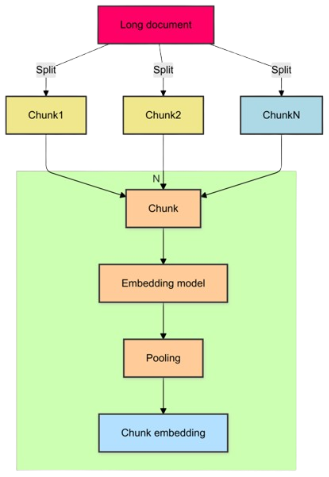


### **Description of work procedure**

1. **รวมไฟล์ Markdown**
    - Loop function เพื่ออ่านไฟล์ Markdown ที่ระบุใน list `markdown_files`.
    - บันทึกลงใน File `parsed_dataMerge.md` โดยมีชื่อ File เป็น header (`# ชื่อไฟล์`)

2. **สร้าง Vector Database**
    - ฟังก์ชัน `create_vector_database` จะเข้าถึง text ทั้งหมดจากไฟล์ Markdown ใน directory `DATA_DIR`.
    - Text ทั้งหมดจะถูกรวมเข้าด้วยกันเป็น string เดียว (`all_text`).
    - `RecursiveCharacterTextSplitter` จะแบ่งข้อความออกเป็น chunks ขนาด 256 tokens  โดยมี overlap 128 tokens.
    - แต่ละ chunk จะถูกแปลงเป็น Document object ของ LlamaIndex.
    - ใช้โมเดล  `BAAI/bge-m3`  จาก Hugging Face  สำหรับสร้าง embeddings สำหรับแต่ละ document.
    - สร้าง Vector Database โดยใช้ FAISS  จาก documents และ embeddings ที่ได้.
    - บันทึก Vector Database ลงใน directory `faiss_index`.
    - Return  `vector_store` (FAISS Vector Database) และ `embed_model`.

In [ ]:
PARSED_DATA_FILE = 'parsed_dataMerge.md'
DATA_DIR = './downloaded_markdown_files/'

markdown_files = [
    "1IZCmAi-5dtNXTt-8yUQaApcUx-xIqa5z.md",
    "1Nwm2JrHRHd98d_2eJAcYrV7YB6DjbuYC.md",
    "1RKEoq-d3U0HWYCWuMfNw_kKPfFcxPE8f.md",
    "1RLK2Y8TsmvBlm8jThqiiaVhACC72Zr4e.md",
    "1WMQ0U-Ex1HsEzQq5gVbhUDSdjUAajaoJ.md",
    "1g5nYN6sQ-vT5VvwEz-BETTTzeROjrojU.md",
    "1nYGLGf6vQwJTnANpFHE_0UHpuBZ2nDo6.md"
]

with open(PARSED_DATA_FILE, "w", encoding="utf-8") as outfile:
    for file in markdown_files:
        file_path = os.path.join(DATA_DIR, file)
        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as infile:
                outfile.write(f"# {file}\n\n")
                outfile.write(infile.read())
                outfile.write("\n\n")
        else:
            print(f"File {file_path} does not exist.")

def create_vector_database(data_dir: str = DATA_DIR) -> Tuple:
    os.makedirs(data_dir, exist_ok=True)
    all_text = ""

    for filename in markdown_files:
        file_path = os.path.join(data_dir, filename)
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                all_text += f.read() + "\n"
        else:
            print(f"File {file_path} does not exist.")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=64)
    chunks = text_splitter.split_text(all_text)
    documents = [Document(page_content=chunk) for chunk in chunks]
    embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
    vector_store = FAISS.from_documents(documents=documents, embedding=embed_model)
    faiss_index_path = os.path.join("faiss_index")
    vector_store.save_local(faiss_index_path)
    return vector_store, embed_model

vector_db, embed_model = create_vector_database()

## **EDA (Exploratory data analysis)**

การทำ EDA สำหรับ RAG คือ exploring and analyzing ข้อมูลที่ใช้ในระบบ เพื่อทำความเข้าใจลักษณะของข้อมูล ความสัมพันธ์ระหว่างข้อมูล และหา insight ที่เป็นประโยชน์ในการพัฒนาและปรับปรุงระบบ การ Visualizing ข้อมูล RAG ช่วยให้เห็นภาพการทำงานของโมเดล ว่าโมเดลเลือกและตีความข้อมูลจาก documents อย่างไรบ้าง


**เครื่องมือ Visualizing ในงานนี้**

*   Retrieval แสดงตัวอย่าง Document ID และ search Embeddings ใน FAISS VectorDB
*   Distribution ระหว่าง query_vector และเวกเตอร์ทั้งหมดใน index
*   Visualizing Word Embeddings ด้วย TensorBoard
*   Visualizing Embeddings ด้วย UMAP





### **Retrieval แสดงตัวอย่าง Document ID และ search Embeddings ใน FAISS VectorDB**

ใช้สำหรับตรวจสอบ Vector Database ว่าทำงานได้ถูกต้อง Embeddings ถูกจัดเก็บและดึงมาได้อย่างถูกต้องหรือไม่ และการค้นหา K-Nearest Neighbors ให้ผลลัพธ์ที่ดีหรือไม่ การแสดงตัวอย่าง Embeddings และ Document ID ที่ตรงกัน ช่วยให้มั่นใจว่าข้อมูลใน Vector Database มีความถูกต้องและสอดคล้องกัน และแสดงการค้นหา K-Nearest Neighbors ว่าทำงานอย่างไร โดยเชื่อมโยง index ของผลลัพธ์กับ Document ID ที่เกี่ยวข้อง

In [ ]:
import faiss
import numpy as np

faiss_index_path = '/content/faiss_index/index.faiss'
index = faiss.read_index(faiss_index_path)
num_vectors_to_retrieve = 10
vectors = []

for i in range(num_vectors_to_retrieve):
    vector = index.reconstruct(i)
    vectors.append(vector)

vectors = np.array(vectors)
print(f"Retrieved vectors: \n{vectors}")
query_vector = np.random.rand(index.d).astype(np.float32)

k = 5

distances, indices = index.search(np.array([query_vector]), k)
print(f"Search results (distances): {distances}")
id_to_text_map = {i: f"Document ID {i}" for i in range(index.ntotal)}
print("\nCorresponding Document IDs for the search results:")
for idx in indices[0]:
    doc_id = id_to_text_map.get(idx, "Unknown Document ID")
    print(f"Index {idx} -> Document ID: {doc_id}")

### **Distribution ระหว่าง query vector และเวกเตอร์ทั้งหมดใน index**

การสร้าง Distribution ของระยะห่างระหว่าง query vector และเวกเตอร์ทั้งหมดใน index ของ FAISS ช่วยให้เห็นภาพรวมของ similarity ของข้อมูลใน Vector Database และสามารถวิเคราะห์ประสิทธิภาพของ Embeddings และการทำงานของระบบ Retrieval ได้ โดย Distribution ที่ดีควรมีลักษณะความคล้ายคลึงกันเป็นกลุ่ม ๆ Histogram และแสดงกลุ่มของระยะทางที่ชัดเจน แต่ถ้า Embeddings ไม่มีคุณภาพ Distribution อาจจะกระจายแบบสุ่ม หรือเบ้ไปทางใดทางหนึ่ง บ่งบอกว่า Embeddings ไม่ได้ capture ความหมายของข้อมูลได้ดี

In [ ]:
import matplotlib.pyplot as plt

distances, _ = index.search(np.array([query_vector]), index.ntotal)
plt.hist(distances[0], bins=20, color='red', alpha=0.7)
plt.title("Distribution of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

### **Visualizing Word Embeddings ด้วย TensorBoard**

ช่วยให้เห็นภาพการกระจายของ Embeddings ใน vector space โดย Embeddings ที่ดีควรจะจัดกลุ่มคำที่มีความหมายใกล้เคียงกันไว้ใกล้ ๆ กัน และแยกคำที่มีความหมายต่างกันออกจากกัน หากพบว่า Embeddings กระจายตัวแบบสุ่ม หรือคำที่มีความหมายต่างกันอยู่ใกล้กัน อาจบ่งบอกถึงปัญหาคุณภาพของ Embeddings เพิ่ม query vector เข้าไปใน visualization ทำให้เห็นตำแหน่งของ query vector เทียบกับ Embeddings อื่น ๆ และเข้าใจว่าทำไมระบบ Retrieval จึงดึงเอกสารบางเอกสารขึ้นมา

In [ ]:
import faiss
import numpy as np
import tensorflow as tf
from tensorboard.plugins import projector
import os

faiss_index_path = '/content/faiss_index/index.faiss'
index = faiss.read_index(faiss_index_path)
num_vectors_to_retrieve = 100
vectors = []
metadata = []

for i in range(num_vectors_to_retrieve):
    vector = index.reconstruct(i)
    vectors.append(vector)
    metadata.append(f"Document ID {i}")

vectors = np.array(vectors)
query_vector = np.random.rand(index.d).astype(np.float32)
k = 10
distances, indices = index.search(np.array([query_vector]), k)
metadata.append("Query Vector")
vectors = np.vstack([vectors, query_vector])

log_dir = "/content/tensorboard_logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

embedding_file = os.path.join(log_dir, "embeddings.tsv")
metadata_file = os.path.join(log_dir, "metadata.tsv")

np.savetxt(embedding_file, vectors, delimiter="\t")
with open(metadata_file, "w") as f:
    f.write("Document\n")
    f.writelines("\n".join(metadata))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embeddings"
embedding.metadata_path = "metadata.tsv"
checkpoint_path = os.path.join(log_dir, "embeddings.ckpt")
checkpoint = tf.train.Checkpoint(embeddings=tf.Variable(vectors, dtype=tf.float32))
checkpoint.save(file_prefix=checkpoint_path)
projector.visualize_embeddings(log_dir, config)

### **Visualizing Embeddings ด้วย UMAP**

การแสดงผล Embeddings ด้วย UMAP (Uniform Manifold Approximation and Projection) เป็นเทคนิคสำคัญในการทำ EDA (Exploratory Data Analysis) ของระบบ RAG โดยเฉพาะอย่างยิ่งเมื่อใช้ FAISS VectorDB. UMAP ช่วยลดมิติของ Embeddings ให้อยู่ใน 2 มิติ เพื่อให้สามารถเห็นการกระจายของข้อมูลได้ ทำให้เข้าใจว่า embeddings ของข้อความต่าง ๆ อยู่กระจายตัวอย่างไรใน vector space ในงานนี้คณะผู้จัดทำใช้สำหรับวิเคราะห์ผลลัพธ์การค้นหา เน้น embeddings ที่ใกล้เคียงกับ question ที่สุด ด้วยสีแดง และ embedding ของ question ด้วยสีน้ำเงิน ทำให้เห็นว่า ผลลัพธ์การค้นหาจาก FAISS มีความเกี่ยวข้องกับคำถามมากน้อยเพียงใด และกระจายตัวอย่างไรเทียบกับข้อมูลอื่น ๆ ในฐานข้อมูล

In [ ]:
import faiss
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from langchain.embeddings import HuggingFaceEmbeddings

faiss_index_path = "/content/faiss_index/index.faiss"
embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
quantizer = faiss.IndexFlatL2(embed_model.client.encode(['test']).shape[1])
index = faiss.IndexIVFFlat(quantizer, embed_model.client.encode(['test']).shape[1], 100, faiss.METRIC_L2)
index.nprobe = 50
index = faiss.read_index(faiss_index_path)

def visualize_embeddings(question, index, embeddings_model, top_k=5):
    question_embedding = embeddings_model.embed_query(question)
    question_embedding = np.array([question_embedding]).astype(np.float32)
    D, I = index.search(question_embedding, top_k + 1)
    all_embeddings = index.reconstruct_n(0, index.ntotal)
    df = pd.DataFrame({
        "id": range(index.ntotal),
        "embedding": list(all_embeddings)
    })
    df['dist'] = np.linalg.norm(all_embeddings - question_embedding, axis=1)
    closest_vectors_indices = I[0][1:]
    embeddings_umap = np.array([np.array(x) for x in df["embedding"]])
    reducer = umap.UMAP()
    embedding_reduced = reducer.fit_transform(embeddings_umap)
    plt.scatter(embedding_reduced[:, 0], embedding_reduced[:, 1], c='gray', alpha=0.2)
    plt.scatter(embedding_reduced[closest_vectors_indices, 0], embedding_reduced[closest_vectors_indices, 1], c='red', alpha=1)
    plt.scatter(embedding_reduced[I[0][0], 0], embedding_reduced[I[0][0], 1], c='blue', alpha=1, marker='*')
    plt.title("UMAP Visualization of Text Embeddings with Question Highlighted")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

question = "การพัฒนาอุตสาหกรรมปทุมธานี"
visualize_embeddings(question, index, embed_model)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/tensorboard_logs

## **LLM Generation Model**

เป็นขั้นตอนโดยรวมของการทำงานใน RAG pipeline ตั้งแต่การ data retrieval, การสร้าง prompt, response generation, และการเชื่อมต่อกับ OpenAI API เพื่อสร้างคำตอบ

In [ ]:
client = OpenAI(
    api_key='sk-GqA4Uj6iZXaykbOzIlFGtmdJr6VqiX94NhhjPZaf81kylRzh',
    base_url='https://api.opentyphoon.ai/v1'
)

def summarize_text(text, max_tokens=512):
    tokens = text.split()
    return ' '.join(tokens[:max_tokens]) + '...' if len(tokens) > max_tokens else text

def generate_response(prompt):
    chat_completion = client.chat.completions.create(
        model="typhoon-v1.5x-70b-instruct",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1024,
        stop=None
    )
    generated_text = chat_completion.choices[0].message.content.strip()
    return generated_text

def retrieve_documents(query, retriever):
    return retriever.get_relevant_documents(query)

def ask_question_with_context(retriever, question):
    retrieved_docs = retrieve_documents(question, retriever)
    summarized_data = summarize_text("\n".join([doc.page_content for doc in retrieved_docs]), max_tokens=512)
    full_prompt = (
        f"Context for Pathum Thani development:\n{summarized_data}\n\n"
        f"New question: {question}"
    )
    response = generate_response(full_prompt)
    return response

retriever = vector_db.as_retriever(search_kwargs={'k': 5})


## ChatBot GrowthVision

In [ ]:
with gr.Blocks(css=".gradio-container {height: 100vh; width: 100vw;}") as demo:
    chatbot = gr.Chatbot(height=600, label="Chat with AI")
    msg = gr.Textbox(label="Ask your question about Pathum Thani Province", placeholder="Type your question here...")
    submit = gr.Button("Submit")

    def respond(message, chat_history):
        chat_history.append(("user", message))
        bot_message = ask_question_with_context(retriever, message)
        chat_history.append(("assistant", bot_message))
        time.sleep(2)
        return "", chat_history

    submit.click(respond, [msg, chatbot], [msg, chatbot])
    msg.submit(respond, [msg, chatbot], [msg, chatbot])

if __name__ == "__main__":
    demo.launch()